### Problem statement and overview of notebook
Time series forecasting is a common problem for many industries. For example, in retail and commerce, sales forecasting helps companies plan resources and manage inventory. In this notebook, monthly corticosteroid drug sales in Australia will be forecasted. The dataset contains monthly drug sales for 17 years. 

Two forecasting methods will be used. The first is Seasonal Autoregressive Integrated Moving Average, or Seasonal ARIMA. As an extension to the widely used ARIMA, seasonal ARIMA models not only trends but also seasonality in univariate time series data. The second forecasting method is a simple Long Short-Term Memory (LSTM) model. As a recurrent neural network, LSTM can model sequences of data with dependencies and therefore is well suited for time series forecasting.  

### Outline of notebook
**1. Data exploration and visualization**

**2. Seasonal ARIMA**
- Inspecting ACF and PCF for parameter selection
- Fitting SARIMA with manually chosen parameters
- Grid searching SARIMA model parameters
- Evaluating SARIMA models

**3. LSTM**
- Data preparation 
- Defining and fitting LSTM model
- Evaluating LSTM model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Data exploration and visualization

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                 parse_dates = ['date'])
df.rename(columns={'value': 'sale'}, inplace=True)
# get month of date and set date column as index
df['month'] = df['date'].apply(lambda x: x.month)
df.set_index('date', inplace=True)
df.head()

,sale,month
date,,
1991-07-01,3.526591,7
1991-08-01,3.180891,8
1991-09-01,3.252221,9
1991-10-01,3.611003,10
1991-11-01,3.565869,11


In [3]:
print('Date ranges from {} to {}.'.format(min(df.index), max(df.index)))

Date ranges from 1991-07-01 00:00:00 to 2008-06-01 00:00:00.


#### Visualize monthly drug sales

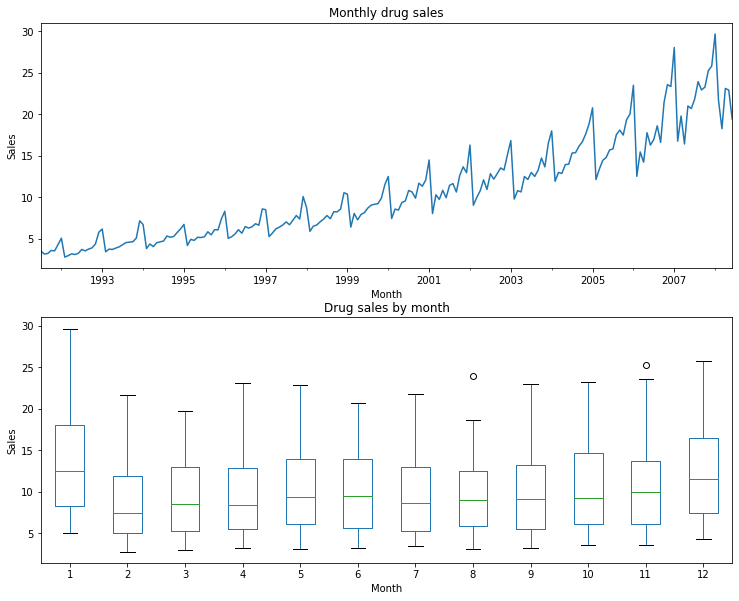

In [4]:
# visualize monthly furniture sales
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

df['sale'].plot(ax=ax[0])
ax[0].set_title('Monthly drug sales')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Sales')

df.boxplot(column='sale', by='month', grid=False, ax=ax[1])
ax[1].set_title('Drug sales by month')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Sales')
fig.suptitle('')
plt.show()

- There appears to be an increasing trend and a seasonality where drug sale drops in Feb and increases in the remaining months and peaks in Jan the following year. 
- The variance of drug sale increases as its mean increases. Will log transform monthly sale to make the variance constant.

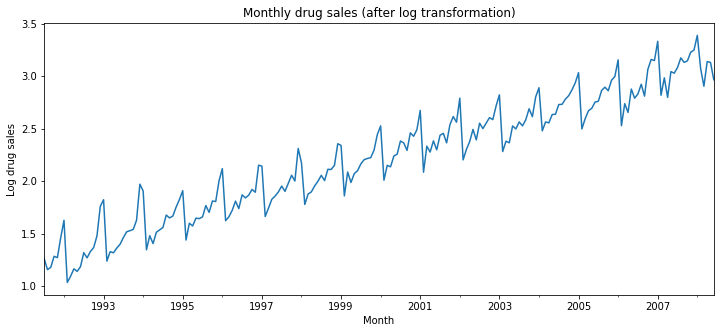

In [5]:
# visualize log transformed sales
df['sale_log'] = np.log(df['sale'])

fig, ax = plt.subplots(figsize=(12, 5))
df['sale_log'].plot(ax=ax)
ax.set_title('Monthly drug sales (after log transformation)')
ax.set_xlabel('Month')
ax.set_ylabel('Log drug sales')
plt.show()

#### Decompose monthly drug sales

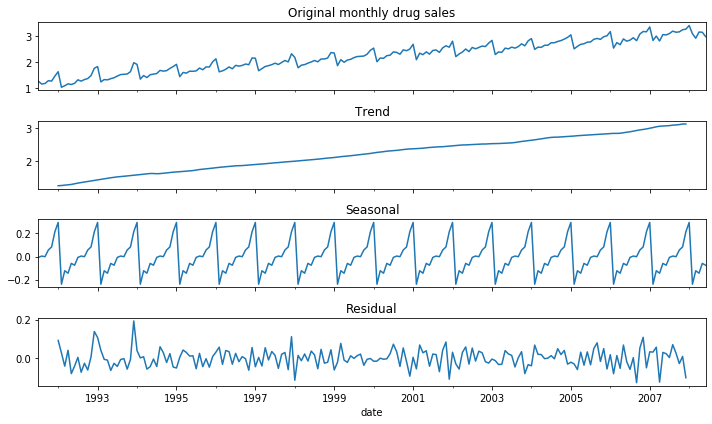

In [6]:
def plot_decomposition(ts, model):
    '''plots different components of time series data
       : original data, trend, seasonal, and residual
    '''
    decomposition = sm.tsa.seasonal_decompose(ts, model=model)
    
    fig, ax = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
    ts.plot(ax=ax[0])
    ax[0].set_title('Original monthly drug sales')
    decomposition.trend.plot(ax=ax[1])
    ax[1].set_title('Trend')
    decomposition.seasonal.plot(ax=ax[2])
    ax[2].set_title('Seasonal')
    decomposition.resid.plot(ax=ax[3])
    ax[3].set_title('Residual')
    plt.tight_layout()
    plt.show()
    
plot_decomposition(df['sale_log'], 'additive')

Again trend and seasonality can be observed in the data; the data is not stationary.

### Seasonal ARIMA

#### Seasonal differencing
Since there is a strong seasonality, seasonal differencing is used to make the series stationary. 

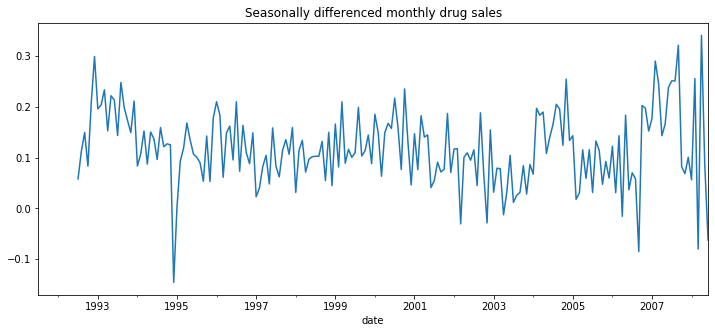

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))
df['sale_log'].diff(12).plot(ax=ax)
ax.set_title('Seasonally differenced monthly drug sales')
plt.show()

Applying seasonal difference on the data removes seasonality. Although the differenced series may still not be stationary, further differencing is not done to avoid possible overdifferencing.  

#### Inspect ACF and PCF of seasonally differenced series to manually select parameters for SARIMA 

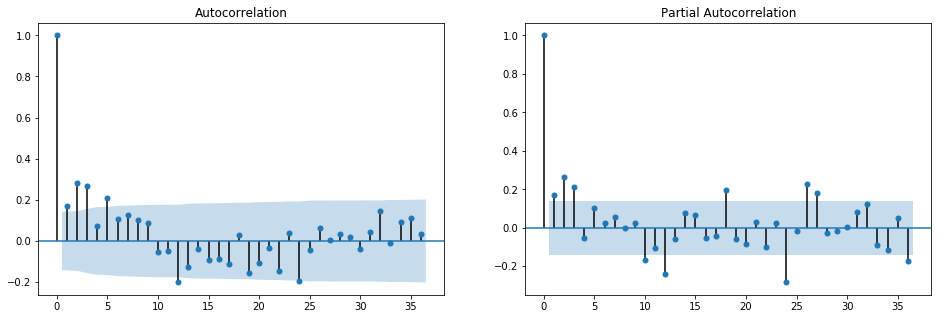

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(df['sale_log'].diff(12).dropna(), ax=ax[0], lags=36)
plot_pacf(df['sale_log'].diff(12).dropna(), ax=ax[1], lags=36)
plt.show()

The partial autocorrelations at the first 3 non-seasonal lags are significant, so set the non-seasonal AR to 3 (**p=3**). The autocorrelations at the first few non-seasonal lags doesn't show a clear pattern, will set the non-seasonal MA to 0 (**q=0**). Non-seasonal difference will also be set to 0 (**d=0**), since no non-seasonal differencing is done. Because the partical autocorrelations at lag 12 and lag 24 are significant, the seasonal AR appears to have an order of 2 (**P=2**). Similarly, the autocorrelations at seasonal lags (lag 12 and 24) are significant, so will set the seasonal MA to 2 (**Q=2**). Seasonal differencing is done, so **D=1**. **SARIMA model (3, 0, 0)(2, 1, 2)12** will be tried.

In [9]:
# train test split
train = df[:int(len(df)*0.75)]
test = df[int(len(df)*0.75):]

#### Fit SARIMA with manually chosen parameters

In [10]:
def fit_sarima(data, p, d, q, P, D, Q, m):
    '''function to fit a seasonal ARIMA model
    '''
    sarima = SARIMAX(data,
                     order=(p, d, q),
                     seasonal_order=(P, D, Q, m),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
    return sarima.fit()

In [11]:
sarima_fitted1 = fit_sarima(train['sale_log'],
                            p=3, d=0, q=0, P=2, D=1, Q=2, m=12)
sarima_fitted1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           sale_log   No. Observations:                  153
Model:             SARIMAX(3, 0, 0)x(2, 1, 2, 12)   Log Likelihood                 169.735
Date:                            Tue, 25 Feb 2020   AIC                           -323.470
Time:                                    14:31:23   BIC                           -301.580
Sample:                                07-01-1991   HQIC                          -314.586
                                     - 03-01-2004                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1959      0.108      1.821      0.069      -0.015       0.407
ar.L2          0.4112      0.083      4.930      0.000       0.248       0.575
ar.L3          0.3883      0.089      4.380      0.000       0.215       0.562
ar.S.L12       0.4232      0.130      3.250      0.001       0.168       0.678
ar.S.L24      -0.3360      0.106     -3.183      0.001      -0.543      -0.129
ma.S.L12      -0.9448      0.173     -5.472      0.000      -1.283      -0.606
ma.S.L24       0.2526      0.159      1.585      0.113      -0.060       0.565
sigma2         0.0027      0.000      8.363      0.000       0.002       0.003
===================================================================================
Ljung-Box (Q):                       32.89   Jarque-Bera (JB):                 4.49
Prob(Q):                              0.78   Prob(JB):                         0.11
Heteroskedasticity (H):               1.04   Skew:                            -0.22
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Make predictions and plot actual vs. predicted sales

In [12]:
def make_out_of_sample_forecast(sarima_fitted, steps):
    '''makes out of sample forecast and confidence intervals of a fitted SARIMA model
       steps: number of steps to forecast into the future
    '''
    forecast = sarima_fitted.get_forecast(steps=steps)
    return forecast.predicted_mean, forecast.conf_int()

In [13]:
def plot_actual_vs_predicted(actual, variable_name, model_name,
                             train_pred, test_pred, test_pred_ci=None):
    '''plots out of sample forecast
    '''
    fig, ax = plt.subplots(figsize=(12, 5))
    actual.plot(ax=ax, label='Actual', alpha=.7)
    train_pred.plot(ax=ax, label='In sample predictions (train data)', alpha=.7)
    test_pred.plot(ax=ax, label='Out of sample predictions (test data)', alpha=.7)
    
    # plot confidence interval if available
    if test_pred_ci is not None:
        ax.fill_between(test_pred_ci.index,
                        test_pred_ci.iloc[:, 0],
                        test_pred_ci.iloc[:, 1],
                        color = 'k', alpha=.2)
        
    ax.set_title('Actual vs predicted '+variable_name+' from '+model_name)
    plt.legend()
    plt.show()

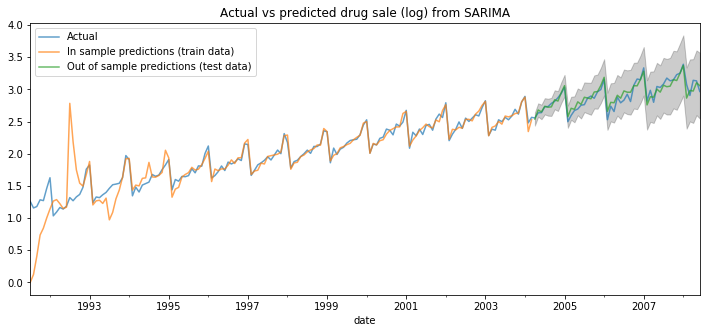

In [14]:
# get predictions for train and test data
train_pred_sarima1 = sarima_fitted1.predict(start=min(train.index), end=max(train.index))
test_pred_sarima1, test_pred_ci_sarima1 = make_out_of_sample_forecast(sarima_fitted1,
                                                                      steps=len(test))
# visualize actual vs predicted sales
plot_actual_vs_predicted(actual=df['sale_log'], variable_name='drug sale (log)',
                         model_name='SARIMA', train_pred=train_pred_sarima1,
                         test_pred=test_pred_sarima1, test_pred_ci=test_pred_ci_sarima1)

#### Get rmse of forecast (on test data)

In [15]:
def get_rmse(actual, predicted):
    return np.mean((predicted - actual)**2)**.5

rmse_sarima1 = get_rmse(test['sale_log'].values, test_pred_sarima1)
print('RMSE of SARIMA forecast: {0:.4f}'.format(rmse_sarima1))

RMSE of SARIMA forecast: 0.0792


The manually chosen SARIMA performs really well on the test data, although its predictions for the train data are off for for the first year or so observations.

#### Use grid search to find best SARIMA model
Manually chosen parameters were used to fit the SARIMA model in the previous section. Alternatively, next I will try grid search to find best model - model that gives lowest rmse on the training data.

In [16]:
def get_params(p_upper, d_upper, q_upper, P_upper, D_upper, Q_upper, m):
    '''function to prepare parameters before grid searching for SARIMA models
       p_upper/q_upper/d_upper: upper boundary of p/d/q parameters (not inclusive)
    '''
    p, d, q = range(p_upper), range(d_upper), range(q_upper)
    P, D, Q = range(P_upper), range(D_upper), range(Q_upper)
    params = list(itertools.product(p, d, q))
    seasonal_params = [(param[0], param[1], param[2], m) for param in itertools.product(P, D, Q)]
    
    return params, seasonal_params

In [17]:
def grid_search_sarima(params, seasonal_params, train):
    '''function to grid search for SARIMA models, returns a dataframe of parameters, AIC, and
       RMSE of different fitted SARIMA models
       params: a list of tuples each specifying p, d, and q
       seasonal_params: a list of tuples each specifying P, D, Q, and m
    '''
    results_list = []
    # for each combination of param and seasonal_param, try fitting SARIMA
    for param in params:
        for seasonal_param in seasonal_params:
            try:
                results = {}
                sarima_fitted = fit_sarima(train, p=param[0], d=param[1], q=param[2],
                                           P=seasonal_param[0], D=seasonal_param[1],
                                           Q=seasonal_param[2], m=seasonal_param[3])
                                
                # store param, seasonal param, AIC fitted SARIMA model in dict
                results['param'] = param
                results['seasonal_param'] = seasonal_param
                results['aic'] = sarima_fitted.aic
                
                # get in sample predictions (on train data)
                pred = sarima_fitted.predict(start=min(train.index), end=max(train.index))
                # calculate rmse of train data
                results['rmse'] = get_rmse(train, pred)
                
                results_list.append(results)
            except:
                continue
    
    # return results as a dataframe
    return pd.DataFrame(results_list)

In [18]:
params, seasonal_params = get_params(p_upper=4, d_upper=2, q_upper=3,
                                     P_upper=3, D_upper=2, Q_upper=3, m=12)
df_results = grid_search_sarima(params, seasonal_params, train['sale_log'])
df_results.sort_values(by='rmse').head()

,param,seasonal_param,aic,rmse
192,"(1, 1, 1)","(2, 0, 0, 12)",-361.356879,0.130587
300,"(2, 1, 1)","(2, 0, 0, 12)",-356.649333,0.130665
194,"(1, 1, 1)","(2, 0, 2, 12)",-369.404658,0.130840
295,"(2, 1, 1)","(1, 0, 1, 12)",-398.369412,0.131013
187,"(1, 1, 1)","(1, 0, 1, 12)",-401.228992,0.131369


Refit model that gives best rmse on train data

In [19]:
sarima_fitted2 = fit_sarima(train['sale_log'],
                            p=1, d=1, q=1, P=2, D=0, Q=0, m=12)
sarima_fitted2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           sale_log   No. Observations:                  153
Model:             SARIMAX(1, 1, 1)x(2, 0, 0, 12)   Log Likelihood                 185.678
Date:                            Tue, 25 Feb 2020   AIC                           -361.357
Time:                                    14:46:24   BIC                           -347.136
Sample:                                07-01-1991   HQIC                          -355.579
                                     - 03-01-2004                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1350      0.110     -1.226      0.220      -0.351       0.081
ma.L1         -0.7953      0.080     -9.979      0.000      -0.951      -0.639
ar.S.L12       0.7403      0.093      7.994      0.000       0.559       0.922
ar.S.L24       0.1682      0.089      1.900      0.057      -0.005       0.342
sigma2         0.0031      0.000      8.366      0.000       0.002       0.004
===================================================================================
Ljung-Box (Q):                       58.34   Jarque-Bera (JB):                11.85
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.42
Prob(H) (two-sided):                  0.69   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Visualize forecast and caculate rmse on test data for the best model

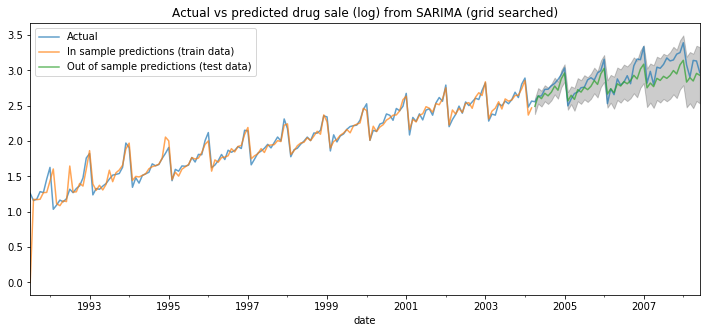

RMSE of SARIMA (grid searched) predictions: 0.1387


In [20]:
train_pred_sarima2 = sarima_fitted2.predict(start=min(train.index), end=max(train.index))
test_pred_sarima2, test_pred_ci_sarima2 = make_out_of_sample_forecast(sarima_fitted2,
                                                                    steps=len(test))
plot_actual_vs_predicted(actual=df['sale_log'], variable_name='drug sale (log)',
                         model_name='SARIMA (grid searched)', train_pred=train_pred_sarima2,
                         test_pred=test_pred_sarima2, test_pred_ci=test_pred_ci_sarima2)

rmse_sarima2 = get_rmse(test['sale_log'], test_pred_sarima2)
print('RMSE of SARIMA (grid searched) predictions: {0:.4f}'.format(rmse_sarima2))

Suprisingly the best model found through grid search produced less accurate forecast for test data than the model with manually picked parameters. The model performs better than the manually chosen one on the train data, but consistently underestimates sales for test data. 

### LSTM

#### Data preparation

Normalize sale data

In [21]:
# set seed for reproducibility
np.random.seed(7)

scaler = MinMaxScaler(feature_range=(0, 1))
df['sale_log_norm'] = scaler.fit_transform(df['sale_log'].values.reshape(-1, 1))

# train test split
train_lstm = df[:int(len(df)*0.75)]
test_lstm = df[int(len(df)*0.75):]

To train LSTM for univariate time series forecast, we would need data in the form of input (X) and output (y), where X is a sequence of past observations and y is the subsequent observation. Suppose monthly sales of a product in say 8 months are 10, 15, 20, 25, 30, 35, 40, 45. We could divide the sales history into multiple samples of X and y. For example, X=[10, 15, 20, 25, 30], y=35; X=[15, 20, 25, 30, 35], y=40; X=[20, 25, 30, 35, 40], y=45 etc. Here 5 time steps are used for X and one time step for y, that is, using sales in each of the past 5 months as input data to predict sales one step into the future.

In [22]:
def prepare_samples(df, time_series_col, n_steps):
    '''prepares samples from a univariate time series column in a df
       each sample has a specified number of time steps (n_steps) of 
       observations as input (X) and a single time step as output (y)
     '''
    # initialize empty list to store X values
    X = []
    for i in range(n_steps, 0, -1):
        lagged = df[time_series_col].shift(periods=i).values
        # the first n_steps values would contain nan, only append from n_steps onwards 
        X.append(lagged[n_steps:])
    
    # X: n_samples, n_steps matrix 
    X = np.array(X).T   
    # y: n_samples, 1 matrix
    y = df[time_series_col][n_steps:].values.reshape(-1, 1)
           
    return X, y

# prepare samples for both train and test data
# set n_steps to 12 to take seasonality into account
N_STEPS = 12
X_train, y_train = prepare_samples(df=train_lstm, time_series_col='sale_log_norm',
                                   n_steps=N_STEPS)
X_test, y_test = prepare_samples(df=test_lstm, time_series_col='sale_log_norm',
                                 n_steps=N_STEPS)

Model will require the input layer to be of shape (number of samples, number of time steps, number of features). Need to reshape X data.

In [23]:
# reshape X form (n_samples, n_steps) to (n_samples, n_steps, n_features)
# since it is univariate time series, the number of features is 1
N_FEATURES = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], N_FEATURES))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], N_FEATURES))

# check train test data shape
X_train.shape, X_test.shape

((141, 12, 1), (39, 12, 1))

#### Define and fit LSTM model

In [24]:
# one LSTM layer with 100 nodes and one output layer with a single node
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(N_STEPS, N_FEATURES)))
model.add(Dense(1))
# use adam as optimizer and mean squared error as loss
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X_train, y_train, epochs=200, verbose=0)

#### Evaluate LSTM predictions on test data

In [25]:
def get_lstm_predictions(model, X, index):
    '''makes predictions for X, transform data to original scale,
       and returns predictions as a pandas series with given datetime
       index as index 
    '''
    pred = scaler.inverse_transform(model.predict(X))
    # change pred to 1d and make series
    pred = pd.Series(pred.ravel(), index=index)
    
    return pred

# get lstm predictions of train and test data
train_pred_lstm = get_lstm_predictions(model=model, X=X_train,
                                       index=train_lstm.index[N_STEPS:])
test_pred_lstm = get_lstm_predictions(model=model, X=X_test,
                                      index=test_lstm.index[N_STEPS:])

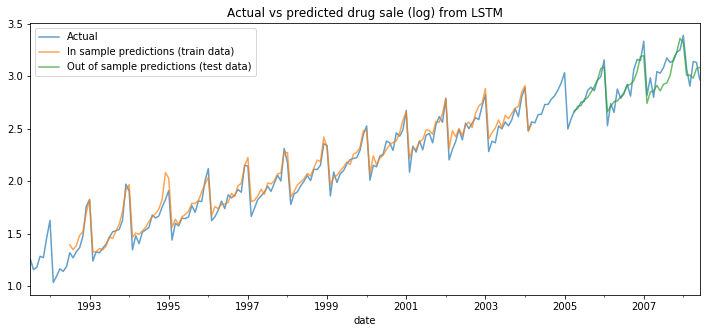

RMSE of LSTM forecast: 0.0970


In [26]:
# visualize actual vs predicted values
plot_actual_vs_predicted(actual=df['sale_log'], variable_name='drug sale (log)',
                         model_name='LSTM', train_pred=train_pred_lstm,
                         test_pred=test_pred_lstm)
# get rmse of test data
rmse_lstm = get_rmse(scaler.inverse_transform(y_test),
                     scaler.inverse_transform(model.predict(X_test)))
print('RMSE of LSTM forecast: {0:.4f}'.format(rmse_lstm))

The LSTM model performs pretty well on both the train and test data. It performs better than the grid searched SARIMA model. Unlike the SARIMA model with manually chosen parameters, LSTM doesn't require manual inspection of data and is much more scalable.